# Compare the goniometer simulation with real data

Code combines plots of the goniometer simulation and real data together

In [1]:
import pandas as pd 
import numpy as np
import livingston_sim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Goniometer simulation code

In [2]:
def get_sign(value):
    """Return the sign of a value: 1 for positive, -1 for negative, 0 for zero."""
    if value > 0:
        return 1
    elif value < 0:
        return -1
    else:
        return 0

In [3]:
# goniometer doesn't know about the photon beam, but does know about backlash
# need separate function to change photon energy based on actual change in diamond angles after backlash

class goniometer:
    """Simulates a goniometer with backlash effects for different run periods."""

    def __init__(self, run_period):
        """Initialize goniometer with orientations and backlash parameters for a given run period.

        Args:
            run_period (str): The run period ('2020', '2023', '2025').
        """
        # possible diamond orientations [should I include amorphous?] 
        self.orientations = ["0/90 PERP","0/90 PARA","45/135 PERP","45/135 PARA"]

        self.current_orientation = "Undefined"
        self.current_set_yaw = 0
        self.current_set_pitch = 0
        self.current_set_roll = 0
        self.current_set_x = 0
        self.current_set_y = 0

        self.current_rbv_yaw = 0
        self.current_rbv_pitch = 0
        self.current_rbv_roll = 0
        self.current_rbv_x = 0
        self.current_rbv_y = 0

        # backlash tracking, will be a number between -2.1 and 2.1 
        self.pitch_recent_moves = 0
        # backlash tracking, will be a number between -4.1 and 4.1 
        self.yaw_recent_moves = 0

        self.current_diamond_pitch = 0
        self.current_diamond_yaw = 0

        # 2.1 millidegrees of backlash in pitch
        self.backlash_pitch = 2.1/1000.0
        # around 4.1 millidegrees of backlash in yaw
        self.backlash_yaw = 4.1/1000.0

        # set rough initial goniometer values for each orientation 
        self.orientation_x = [0, 0, 0, 0]
        self.orientation_y = [0, 0, 0, 0]

        # based on data from each run period
        if run_period=="2020":
            self.orientation_pitch = [0.39,-0.73,0.39,1.81]
            self.orientation_yaw = [1.4,2.4,0.73,0.84]
            self.orientation_roll = [-10.5,-10.5,34.5,34.5]
        elif run_period=="2023":
            self.orientation_pitch = [-0.66,0.33,-1.75,-0.28]
            self.orientation_yaw = [0.17,1.28,0.96,1.06]
            self.orientation_roll = [162,162,-153,-153]
        elif run_period=="2025":
            self.orientation_pitch = [1.68,0.59,0.46,0.46]
            self.orientation_yaw = [1.52,1.94,1.94,0.49]
            self.orientation_roll = [-16.6, -16.6, 28.4, 28.4]
        else:
            print("Run period",run_period,"not currently set up")
            exit(0)
    

    # change orientation, track direction for backlash accounting (done in change_diamond_angles)
    def change_orientation(self, new_orientation):
        """Change the goniometer orientation and update angles accordingly.

        Args:
            new_orientation (str): The new orientation name.
        """
        orientation_index = self.orientations.index(new_orientation)

        initial_pitch = self.current_set_pitch 
        initial_yaw = self.current_set_yaw 
        initial_roll = self.current_set_roll

        # set angle values change immediately (could add time delayed rbv)
        self.current_set_pitch = self.orientation_pitch[orientation_index]
        self.current_set_yaw = self.orientation_yaw[orientation_index]
        self.current_set_roll = self.orientation_roll[orientation_index]

        # size and sign of angle change in each direction
        nudge_pitch = self.current_set_pitch - initial_pitch 
        nudge_yaw = self.current_set_yaw - initial_yaw 
        nudge_roll = self.current_set_roll - initial_roll

        # change the diamond angles, accounting for backlash (no roll, not needed for energy changes)
        self.change_diamond_angles("pitch", nudge_pitch)
        self.change_diamond_angles("yaw",nudge_yaw)

        # tell the motors to start moving (modify readback values)
        self.start_your_engines("pitch",nudge_pitch)
        self.start_your_engines("yaw",nudge_yaw)
        self.start_your_engines("roll",nudge_roll)
        


    # here we eventually want the readback value to step in time, for now, just immediately set it to the right value since we don't know the motor speeds 
    def start_your_engines(self, motor, signed_nudge_size):
        """Simulate motor movement by updating readback values.

        Args:
            motor (str): The motor name ('pitch', 'yaw', 'roll', 'x', 'y').
            signed_nudge_size (float): The size of the nudge.
        """
        if motor=="pitch":
            motor_speed = 0.001 # totally guess that it is 1 millidegree a second
            self.current_rbv_pitch += signed_nudge_size
            # maybe change diamond angles here too?

        if motor=="yaw":
            motor_speed = 0.001
            self.current_rbv_yaw += signed_nudge_size 

        if motor=="roll":
            motor_speed = 0.01
            self.current_rbv_roll += signed_nudge_size 

        if motor=="x":
            motor_speed = 0.5 
            self.current_rbv_x += signed_nudge_size 
            
        if motor=="y":
            motor_speed = 0.5 
            self.current_rbv_y += signed_nudge_size


    # this is where we account for backlash
    def change_diamond_angles(self, motor, signed_nudge_size):
        """Update diamond angles accounting for backlash.

        Args:
            motor (str): The motor ('pitch' or 'yaw').
            signed_nudge_size (float): The signed nudge size.
        """
        if abs(signed_nudge_size)<0.0001:
            print("nudge of size less than a 1/10 millidegree given, ignoring")
            return

        if motor=="pitch":
                
            # nudge needs to be same sign as recent_moves and recent_moves needs to be +/- 2.1 for no backlash
            if get_sign(signed_nudge_size)*self.backlash_pitch!=self.pitch_recent_moves:
                # amount of backlash is bigger than the current nudge, so diamond angle won't change
                if abs(self.pitch_recent_moves+2.0*signed_nudge_size)<self.backlash_pitch:
                    # but progress is made towards clearing the backlash
                    self.pitch_recent_moves+=2.0*signed_nudge_size 
                else:
                    # have backlash that will be partially cancelled 
                    nudge_amount_cancelled = (self.backlash_pitch-abs(self.pitch_recent_moves))/2.0
                    actual_nudge_size_signed = signed_nudge_size-get_sign(signed_nudge_size)*nudge_amount_cancelled
                    self.current_diamond_pitch+=actual_nudge_size_signed
                    self.pitch_recent_moves = get_sign(actual_nudge_size_signed)*self.backlash_pitch
            else:
                # just change the diamond angle by the requested amount 
                self.pitch_recent_moves+=2.0*signed_nudge_size
                self.current_diamond_pitch+=signed_nudge_size
                if abs(self.pitch_recent_moves)>self.backlash_pitch:
                    # max size of recent moves should be max size of the backlash, but keep the correct sign
                    self.pitch_recent_moves = get_sign(self.pitch_recent_moves)*self.backlash_pitch
        
        elif motor == "yaw":
            if get_sign(signed_nudge_size)*self.backlash_yaw!=self.yaw_recent_moves:
                # amount of backlash is bigger than the current nudge, so diamond angle won't change
                if abs(self.yaw_recent_moves+2.0*signed_nudge_size)<self.backlash_yaw:
                    # but progress is made towards clearing the backlash
                    self.yaw_recent_moves+=2.0*signed_nudge_size 
                else:
                     # backlash should be cleared, but we will have a less effective nudge
                    nudge_amount_cancelled = (self.backlash_yaw-abs(self.yaw_recent_moves))/2.0
                    actual_nudge_size_signed = signed_nudge_size-get_sign(signed_nudge_size)*nudge_amount_cancelled
                    self.current_diamond_yaw+=actual_nudge_size_signed
                    self.yaw_recent_moves = get_sign(actual_nudge_size_signed)*self.backlash_yaw


            else:# no backlash
                self.yaw_recent_moves+=2.0*signed_nudge_size
                self.current_diamond_yaw+=signed_nudge_size

                if abs(self.yaw_recent_moves)>self.backlash_yaw:
                    self.yaw_recent_moves = get_sign(self.yaw_recent_moves)*self.backlash_yaw


    def do_nudge(self, motor, nudge_size_signed):
        """Perform a nudge on the specified motor.

        Args:
            motor (str): The motor ('pitch' or 'yaw').
            nudge_size_signed (float): The signed nudge size.
        """
        if motor=="pitch":
            self.current_set_pitch += nudge_size_signed 
            self.change_diamond_angles(motor,nudge_size_signed)
            self.start_your_engines(motor,nudge_size_signed)

        elif motor=="yaw":
            self.current_set_yaw += nudge_size_signed
            self.change_diamond_angles(motor,nudge_size_signed)
            self.start_your_engines(motor,nudge_size_signed)


    def print_state(self):
        """Print the current state of the goniometer."""
        print("current set pitch is",self.current_set_pitch)
        print("current set yaw is",self.current_set_yaw)
        print("current set roll is",self.current_set_roll)

        print("current diamond pitch is",self.current_diamond_pitch)
        print("current diamond yaw is",self.current_diamond_yaw)

        print("current pitch recent moves is",self.pitch_recent_moves)
        print("current yaw recent moves is",self.yaw_recent_moves)


    def return_state(self):
        """Return the current state as a dictionary."""
        return {"pitch_set":self.current_set_pitch, "yaw_set":self.current_set_yaw,  "diamond_pitch":self.current_diamond_pitch, "diamond_yaw":self.current_diamond_yaw}
            
    def return_diamond_pitch(self):
        """Return the current diamond pitch."""
        return self.current_diamond_pitch
    
    def return_diamond_yaw(self):
        """Return the current diamond yaw."""
        return self.current_diamond_yaw
    
    def return_set_pitch(self):
        """Return the current set pitch."""
        return self.current_set_pitch
    
    def return_set_yaw(self):
        """Return the current set yaw."""
        return self.current_set_yaw
    
    def return_set_roll(self):
        """Return the current set roll."""
        return self.current_set_roll

In [4]:
def set_orientation_mode(gonio_obj, orientationMode):
    """Set the orientation mode on a goniometer object.

    Args:
        gonio_obj: The goniometer object.
        orientationMode (int): Orientation mode (1-4).
    """
    if orientationMode==1:
        gonio_obj.change_orientation("0/90 PERP")
        return "0/90 PERP"
    elif orientationMode==2:
        gonio_obj.change_orientation("0/90 PARA")
        return "0/90 PARA"
    elif orientationMode==3:
        gonio_obj.change_orientation("45/135 PERP")
        return "45/135 PERP"
    elif orientationMode==4:
        gonio_obj.change_orientation("45/135 PARA")
        return "45/135 PARA"
    else:
        print("orientationMode",orientationMode,"not defined")
    

In [5]:
# to start, just time series of energy as a Gaussian with 3 MeV noise
# nudge_times is list of times for each nudge 
# nudge_directions gives the sign of each nudge 
# orientation mode is 1 0/90 PERP, 2 0/90 PARA, 3 45/135 PERP, 4 45/135 PARA

class sim_engine:
    """Simulation engine for goniometer and energy changes with nudges and backlash."""

    def __init__(self,run_period, orientation_mode):
        """Initialize the simulation engine.

        Args:
            run_period (str): The run period.
            orientation_mode (int): Orientation mode (1-4).
        """
        self.run_period = run_period
        self.orientation_mode = orientation_mode

        self.nudge_energy_size_pitch = 10.0
        self.nudge_energy_size_yaw = 10.0

        self.e_vals = []
        self.e_vals_formula = [] # energy values from ken livingston formula
        self.e_vals_env = [] # energy values from environmental model
        self.times = []
        self.pitch_vals = []
        self.yaw_vals = []
        self.diamond_pitch_vals = []
        self.diamond_yaw_vals = []

        self.nudge_times = []
        self.pitch_diffs = []
        self.yaw_diffs = []

        self.nudge_effectiveness = []

        self.energy_changes = []
        self.energy_change_formula = []

        self.last_time = 0

        # default params for Al radiator
        
        self.plane_val = "Undefined"
        if orientation_mode in [2,4]: # can't do %2, because 0 is a good orientationMode for Al radiator
            self.plane_val = "PARA"
        else:
            self.plane_val = "PERP"

        self.roll_val = 0 # set roll to zero for Al by default
        self.ebeam_current = 300

        self.my_goni = goniometer(run_period)
        self.orientation_str = set_orientation_mode(self.my_goni,orientation_mode)


        self.ebeam_x = -0.5
        self.ebeam_y = 1.0

        # run period specific params
        if run_period=='2020':
            self.goal_energy = 8600
            self.cbrem_unc = 25
            self.ebeam_energy = 11377 # 3 MeV of noise?
            self.ac_x = 1.0
            self.ac_y = -0.2
            self.ebeam_current = 350 # same regardless of radiator

        elif run_period=="2023":
            self.goal_energy = 8620
            self.cbrem_unc = 18
            self.ebeam_energy = 11549
            self.ac_x = -0.5
            self.ac_y = 1.0
            self.ebeam_current = 300 # same regardless of radiator

        elif run_period=="2025":
            self.goal_energy = 8900
            self.cbrem_unc = 25
            self.ebeam_energy = 11688
            self.ac_x = 0.0
            self.ac_y = 0.15
            self.ebeam_current = 300 # for Al radiator

            if orientation_mode in [1,2,3,4]:
                self.ebeam_current = 200 # for any diamond radiator orientation 
        

    def get_data(self):
        """Return the simulation data as a dictionary."""
        return {"TimeStamp":self.times,"GONI:PITCH":self.pitch_vals,"GONI:YAW":self.yaw_vals,"CBREM:ENERGY":self.e_vals}
    



    def generate_flat_timestep(self, input_energy, noise_size):
        """Generate a flat energy timestep with noise.

        Args:
            input_energy (float): The base energy.
            noise_size (float): The noise size.

        Returns:
            float: The base energy.
        """
        base_energy = input_energy 

        current_e = np.random.normal(base_energy,noise_size)

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw() 

        current_diamond_pitch = self.my_goni.return_diamond_pitch()
        current_diamond_yaw = self.my_goni.return_diamond_yaw()

        new_time = self.last_time+1 

        self.e_vals.append(current_e)
        self.e_vals_formula.append(current_e) # flat timestep, so formula energy is same as cobrem energy
        self.e_vals_env.append(current_e) # flat timestep, so env energy is same as cobrem energy

        self.times.append(new_time)
        self.pitch_vals.append(current_pitch)
        self.yaw_vals.append(current_yaw)

        self.diamond_pitch_vals.append(current_diamond_pitch)
        self.diamond_yaw_vals.append(current_diamond_yaw)

        self.last_time = new_time
        return base_energy
        


    # then, RL could hook into generate_timestep by telling it to nudge 
    def generate_nudge_timestep(self, input_energy, input_energy_formula, input_energy_env, noise_size, nudge_direction, time_delay_on=True, next_nudge_time=100000):
        """Generate a timestep with a nudge, accounting for backlash and time delays.

        Args:
            input_energy (float): Base energy.
            input_energy_formula (float): Base energy from formula.
            noise_size (float): Noise size.
            nudge_direction (int): Direction of nudge.
            time_delay_on (bool): Whether to simulate time delay.
            next_nudge_time (float): Time of next nudge.

        Returns:
            tuple: New base energies.
        """
        # angles will immediately update, but simulate with flat model for 5-10 seconds to mimic time delay of nudges

        base_energy = input_energy
        current_e = input_energy

        # ken livingston formula energy
        base_energy_formula = input_energy_formula
        current_e_formula = input_energy_formula

        # energy from env model
        base_energy_env = input_energy_env
        current_e_env = input_energy_env

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw() 

        new_time = self.last_time+1 

        base_step = 1.0/1000.0 # in degrees

                # size and direction of the change in energy
    
    
        # if self.orientation_mode==1:
        step_size = abs(nudge_direction * base_step)# in degrees


        prev_pitch = self.my_goni.return_set_pitch() 
        prev_yaw = self.my_goni.return_set_yaw()

        prev_diamond_pitch = self.my_goni.return_diamond_pitch()
        prev_diamond_yaw = self.my_goni.return_diamond_yaw()




        # this bit is a little messy, but here we keep track of the angle change that results in the energy change we want, which varies by run period

        # actually change pitch/yaw here. signs reverse for 0/90 PERP in Spring 23, for 45/135 PERP in Spring 25
        if self.orientation_mode==1:# 0/90 PERP
            if self.run_period!='2023':
                self.my_goni.do_nudge("pitch",-nudge_direction*step_size)# positive pitch change results in lower energy (at least for Spring 20)
                
                _, new_energy_env = self.my_sim_env.step(
                    dpitch_deg=-nudge_direction*step_size,
                    dyaw_deg=0.0,
                    delta_dose=0.0
                )
            
            else:
                self.my_goni.do_nudge("pitch",nudge_direction*step_size) # positive pitch change results in higher energy (at least for Spring 20)
                _, new_energy_env = self.my_sim_env.step(
                    dpitch_deg=nudge_direction*step_size,
                    dyaw_deg=0.0,
                    delta_dose=0.0
                )

        if self.orientation_mode==2: # 0/90 PARA
            self.my_goni.do_nudge("yaw",-nudge_direction*step_size)
            _, new_energy_env = self.my_sim_env.step(
                dpitch_deg=0.0,
                dyaw_deg=-nudge_direction*step_size,
                delta_dose=0.
            )

        if self.orientation_mode==3: # 45/135 PERP
            if self.run_period!='2025':
                self.my_goni.do_nudge("yaw",-nudge_direction*step_size/(2**0.5))
                self.my_goni.do_nudge("pitch",nudge_direction*step_size/(2**0.5))

                _, new_energy_env = self.my_sim_env.step(
                    dpitch_deg=nudge_direction*step_size/(2**0.5),
                    dyaw_deg=-nudge_direction*step_size/(2**0.5),
                    delta_dose=0.0
                )

            else:
                self.my_goni.do_nudge("yaw",nudge_direction*step_size/(2**0.5))
                self.my_goni.do_nudge("pitch",-nudge_direction*step_size/(2**0.5))

                _, new_energy_env = self.my_sim_env.step(
                    dpitch_deg=-nudge_direction*step_size/(2**0.5),
                    dyaw_deg=nudge_direction*step_size/(2**0.5),
                    delta_dose=0.0
                )
            
        if self.orientation_mode==4: # 45/135 PARA
            self.my_goni.do_nudge("yaw",-nudge_direction*step_size/(2**0.5))
            self.my_goni.do_nudge("pitch",-nudge_direction*step_size/(2**0.5))

            _, new_energy_env = self.my_sim_env.step(
                dpitch_deg=-nudge_direction*step_size/(2**0.5),
                dyaw_deg=-nudge_direction*step_size/(2**0.5),
                delta_dose=0.0
            )


        current_diamond_pitch = self.my_goni.return_diamond_pitch()
        current_diamond_yaw = self.my_goni.return_diamond_yaw()

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw()
            
        yaw_diff = current_yaw-prev_yaw 
        pitch_diff = current_pitch-prev_pitch 
        

        current_effectiveness = ((current_diamond_pitch-prev_diamond_pitch)**2+(current_diamond_yaw-prev_diamond_yaw)**2)**0.5/0.001

        if current_effectiveness>1.5:# for big nudges
            print(f"Big nudge detected with effectiveness: {current_effectiveness}  (supressing by x0.1)")
            current_effectiveness = current_effectiveness/10.0

        energy_change = nudge_direction*((current_diamond_pitch-prev_diamond_pitch)**2 * self.nudge_energy_size_pitch**2 + (current_diamond_yaw-prev_diamond_yaw)**2 * self.nudge_energy_size_yaw**2)**0.5/0.001
        # print("energy change is",energy_change)

        # energy change from ken livingston formula
        k_over_g = 26.5601 / 2 # MeV
        delta_c = ((current_diamond_pitch-prev_diamond_pitch)**2 + (current_diamond_yaw-prev_diamond_yaw)**2)**0.5
        delta_c = delta_c * (np.pi/180.0)
        # print("delta_c is",delta_c)

        delta_energy_formula = nudge_direction*(delta_c* (self.ebeam_energy - base_energy_formula)**2 / (k_over_g + delta_c * (self.ebeam_energy - base_energy_formula)))
        # print("delta_energy_formula is",delta_energy_formula)

        


        if time_delay_on:
            # then sim 8-10 seconds of flat energy before energy changes 
            num_secs = min(new_time+np.random.choice([8,9,10]),next_nudge_time)-new_time# need min of these to prevent skipping nudges when replicating actual runs
            print("num_secs is",num_secs)
            for k in range(num_secs):
                current_e = np.random.normal(input_energy,noise_size)
                current_e_formula = np.random.normal(input_energy_formula,noise_size)
                current_e_env = np.random.normal(input_energy_env,noise_size)

                if k==0:# time when the nudge occurred
                    self.yaw_diffs.append(yaw_diff)
                    self.pitch_diffs.append(pitch_diff)
                    self.nudge_times.append(new_time)
                    self.energy_changes.append(energy_change)
                    self.energy_change_formula.append(delta_energy_formula)
                    self.nudge_effectiveness.append(current_effectiveness)

                self.e_vals.append(current_e)
                self.e_vals_formula.append(current_e_formula)
                self.e_vals_env.append(current_e_env)


                self.times.append(new_time)
                self.pitch_vals.append(current_pitch)
                self.yaw_vals.append(current_yaw)

                self.diamond_pitch_vals.append(current_diamond_pitch)
                self.diamond_yaw_vals.append(current_diamond_yaw)
                new_time+=1


        base_energy += energy_change
        base_energy_formula += delta_energy_formula
        base_energy_env = new_energy_env

        print("base_energy after nudge is",base_energy)
        print("base_energy_formula after nudge is",base_energy_formula)
        print("base_energy_env after nudge is",base_energy_env)

        # include noise
        current_e = np.random.normal(base_energy,noise_size)
        current_e_formula = np.random.normal(base_energy_formula,noise_size)
        current_e_env = np.random.normal(base_energy_env,noise_size)



        #print("base_energy is",base_energy)
        self.e_vals.append(current_e)
        self.e_vals_formula.append(current_e_formula)
        self.e_vals_env.append(current_e_env)
        self.times.append(new_time)

        
        self.pitch_vals.append(current_pitch)
        self.yaw_vals.append(current_yaw)

        self.diamond_pitch_vals.append(current_diamond_pitch)
        self.diamond_yaw_vals.append(current_diamond_yaw)

        self.last_time = new_time

        return base_energy, base_energy_formula, base_energy_env # new base energy is different, note current e is base + noise, base is the "true" energy



    def generate_linear_step(self, input_energy,noise_size,model_param=0):# param is just the slope
        """Generate a linear drift timestep.

        Args:
            input_energy (float): Base energy.
            noise_size (float): Noise size.
            model_param (float): Slope parameter.

        Returns:
            float: New base energy.
        """
        base_energy = input_energy 
        new_time = self.last_time+1

        current_pitch = self.my_goni.return_set_pitch()
        current_yaw = self.my_goni.return_set_yaw() 
        current_diamond_pitch = self.my_goni.return_diamond_pitch()
        current_diamond_yaw = self.my_goni.return_diamond_yaw()

        base_energy+=model_param

        current_e = np.random.normal(base_energy,noise_size)

        self.e_vals.append(current_e)
        self.times.append(new_time)
        self.pitch_vals.append(current_pitch)
        self.yaw_vals.append(current_yaw)

        self.diamond_pitch_vals.append(current_diamond_pitch)
        self.diamond_yaw_vals.append(current_diamond_yaw)

        self.last_time = new_time 

        return base_energy


    # for sine model
    # model params will be normalization and period, maybe offset?
    #modified_base_energy=base_energy+model_params[0]*np.sin(i*2*np.pi/(model_params[1]))

    # everything done in generate_nudge_timestep, generate_flat_timestep, etc, just get right number of seconds here
    def generate_timeseries(self, num_seconds, input_energy, noise_size, energy_drift_model = 'None', model_params=[], auto_nudge = False):
        """Generate a time series of energy data.

        Args:
            num_seconds (int): Number of seconds to simulate.
            input_energy (float): Initial energy.
            noise_size (float): Noise size.
            energy_drift_model (str): Drift model ('None', 'linear', 'sine', 'manual').
            model_params (list): Parameters for the model.
            auto_nudge (bool): Whether to auto-nudge.
        """
        current_time = self.last_time 
        end_time = current_time+num_seconds
        current_energy = input_energy
        current_energy_formula = input_energy
        current_energy_env = input_energy

        orientation_str = ' '.join(self.orientation_str.split()[::-1])
        self.my_sim_env = livingston_sim.CoherentBremsstrahlungSimulator(
            base_peak_position=current_energy_env,   # MeV
            dose_slope=0.0,            # MeV per dose unit
            beam_energy_E0=self.ebeam_energy,      # MeV
            coherent_edge_Ei=current_energy_env,  # MeV
            orientation=orientation_str,
            run_period=self.run_period,
        )
        self.my_sim_env.beam_state.beam_pitch_deg = 0.0
        self.my_sim_env.beam_state.beam_yaw_deg = 0.0

        while current_time<end_time:

            if energy_drift_model=="None":
                current_energy = self.generate_flat_timestep(current_energy,noise_size)
            elif energy_drift_model=="linear":
                current_energy = self.generate_linear_step(current_energy,noise_size,model_params[0])
            elif energy_drift_model=="sine":
                print("not supported yet")
                return 
            elif energy_drift_model=="manual":
                # here we have a list of nudge times and directions
                nudge_times = model_params[0]
                nudge_directions = model_params[1]
                if current_time in nudge_times:
                    nudge_index = nudge_times.index(current_time)
                    next_nudge_time = 1000000
                    if len(nudge_times)-1>nudge_index:
                        next_nudge_time = nudge_times[nudge_index+1]

                    current_energy, current_energy_formula, current_energy_env = self.generate_nudge_timestep(current_energy, current_energy_formula, current_energy_env, noise_size,nudge_directions[nudge_index],True,next_nudge_time)
                else:
                    current_energy = self.generate_flat_timestep(current_energy,noise_size)

            # nudge step can be up to 11 seconds on its own
            current_time = self.last_time


    def plot_result(self,x_window=[],y_window=[20,20],title="",save_as=""):
        """Plot the simulation results.

        Args:
            x_window (list): X-axis window.
            y_window (list): Y-axis window.
            title (str): Plot title.
            save_as (str): File to save plot to.

        Returns:
            matplotlib.axes.Axes: The first axis.
        """
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,figsize=(6,10),sharex=True)
        
        ax1.plot(self.times,self.e_vals, label='Simulated Cobrem Edge', color='magenta', alpha=0.7)
        ax1.plot(self.times,self.e_vals_formula, label='Simulated from Formula', color='brown', alpha=0.7)
        ax1.plot(self.times,self.e_vals_env, label='Simulated from Env Model', color='cyan', alpha=0.7)
        ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
        ax1.set_title(title)

        for time_index in range(len(self.nudge_times)):
            # draw vertical dashed line for each nudge, with width representing total nudge angle
            current_energy_change = self.energy_changes[time_index]
            # calculate total nudge angle in quadrature
            pitch_diff = self.pitch_diffs[time_index]
            yaw_diff = self.yaw_diffs[time_index]
            total_nudge_angle = (pitch_diff**2 + yaw_diff**2)**0.5
            # scale linewidth: minimum 0.5, scale by factor of 1000 to make visible differences
            linewidth = max(0.5, abs(total_nudge_angle) * 1000)
            
            print(f"Nudge {time_index}: pitch_diff={pitch_diff:.6f}, yaw_diff={yaw_diff:.6f}, total_angle={total_nudge_angle:.6f}, linewidth={linewidth:.2f}")
            
            if current_energy_change<0:
                ax1.axvline(self.nudge_times[time_index],linestyle='--',color='red',alpha=0.5,linewidth=linewidth)
            elif current_energy_change>0:
                ax1.axvline(self.nudge_times[time_index],linestyle='--',color='blue',alpha=0.5,linewidth=linewidth)
            else:
                ax1.axvline(self.nudge_times[time_index],linestyle='--',color='gray',alpha=0.5,linewidth=linewidth)
    
        ax1.set_ylabel("$E_{\gamma}$ [MeV]")
        ax1.axhline(self.goal_energy,color='g')
        ax1.axhspan(self.goal_energy-10,self.goal_energy+10,color='g',alpha=0.1,label='Goal ±10 MeV')
        ax1.set_ylim(self.goal_energy-y_window[0],self.goal_energy+y_window[1])
        ax1.legend()

        ax2.plot(self.nudge_times,self.nudge_effectiveness,marker='o',color='black')
        ax2.set_ylabel("Nudge Effectiveness")
        ax2.axhline(1.0,color='black',alpha=0.2,linestyle='--')
        ax2.axhline(0.0,color='black',alpha=0.2,linestyle='--')

        ax3.plot(self.nudge_times,self.yaw_diffs,marker='o',label='YawDiff',color='blue')
        ax3.plot(self.nudge_times,self.pitch_diffs,marker='o',label='PitchDiff',color='orange')
        ax3.set_ylabel("Nudge Size (deg.)")
        ax3.legend()

        ax4.plot(self.times,self.pitch_vals,color='orange')
        ax4.set_ylabel('Pitch (deg.)')
        ax4.tick_params('y',colors='orange')

        ax4b = ax4.twinx()
        ax4b.plot(self.times,self.yaw_vals,color='blue')
        ax4.set_xlabel("Time (s)")
        ax4b.set_ylabel('Yaw (deg.)')
        ax4b.tick_params('y',colors='blue')

        #ax4.legend()

        if x_window!=[]:
            ax1.set_xlim(x_window[0],x_window[1])
            ax2.set_xlim(x_window[0],x_window[1])
            ax3.set_xlim(x_window[0],x_window[1])

        if save_as!="":
            plt.tight_layout()
            plt.savefig(save_as)

        return ax1


<>:478: SyntaxWarning: invalid escape sequence '\g'
<>:478: SyntaxWarning: invalid escape sequence '\g'
/scratch/gjwei/ipykernel_2258160/3750223356.py:478: SyntaxWarning: invalid escape sequence '\g'
  ax1.set_ylabel("$E_{\gamma}$ [MeV]")


# Prepare real data

# Simulation Engine

In [6]:
# select runs with multiple nudges. Not removing runs with backlash, but manually go through to make sure nudges are monotonic. Some 45/135 runs are flagged as backlash, when it seems like there isn't any
def select_data(df_in):
    df_out = df_in[(df_in['goodRun'])&(df_in['RunHasNudge'])&(df_in['TotalNudges_thisRun']>=1)]
    return df_out

In [7]:
# start and end times are for measuring energy, trim_start_end actually modifies the time axes
def if_backlash_exist(df_in, runNumber, start_times=[], end_times=[],y_lims = []):
    """Check if backlash exists in a run based on nudge effectiveness.

    Args:
        df_in: DataFrame with run data.
        runNumber (int): The run number.
        start_times (list): Start times.
        end_times (list): End times.
        y_lims (list): Y limits.

    Returns:
        bool: True if backlash exists.
    """
    print("select run ",runNumber)

    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600
    roll_0_90 = -10.5
    roll_45_135 = 34.5

    if (runNumber>80000) and (runNumber < 130000):
        minE = 8520
        maxE = 8720
        expectedE = 8620
    elif runNumber>130000:
        minE = 8800
        maxE = 9000
        expectedE = 8900

    df_run = df_in[df_in['RunNumber']==runNumber]

    # should plot backlash nudges too, so we know if we are near one
    df_run_nudges = df_run[(df_run['NudgeOccurred'])]
    nudge_list = df_run_nudges['NudgeNumber'].unique()


    backlash_happen = False

    for seq in nudge_list:

        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        nudge_time = df_this_nudge['TimeStamp'].min()
        nudge_effectiveness = df_this_nudge['NudgeEffectiveness'].mode()[0]
        nudge_effectiveness_pitch = df_this_nudge['NudgeEffectivenessPitch'].mode()[0]
        nudge_effectiveness_yaw = df_this_nudge['NudgeEffectivenessYaw'].mode()[0]

        
        current_pitchDiff = max(df_this_nudge['NudgePitchSize'].unique(), key=abs)  
        current_yawDiff = max(df_this_nudge['NudgeYawSize'].unique(), key=abs)

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>0.5 or abs(current_yawDiff)>0.5:
            # print(df_this_nudge)
            continue
            

        if abs(nudge_effectiveness_pitch)<0.8:
            print("pitch effectiveness: ", nudge_effectiveness_pitch)
            backlash_happen = True
            break

        if abs(nudge_effectiveness_yaw)<0.8:
            print("yaw effectiveness: ", nudge_effectiveness_yaw)
            backlash_happen = True
            break
    
    return backlash_happen

# Data Analysis Functions

In [8]:
df_2020 = pd.read_csv("Spring2020_Merged_goodRuns_nudgesDefined.csv")
df_2023 = pd.read_csv("Spring2023_Merged_goodRuns_nudgesDefined.csv")
df_2025 = pd.read_csv("Spring2025_Merged_goodRuns_nudgesDefined.csv")

print("Spring 2020 columns:")
print(df_2020.columns.tolist())
print("\nSpring 2023 columns:")
print(df_2023.columns.tolist())
print("\nSpring 2025 columns:")
print(df_2025.columns.tolist())

df_2020_good = select_data(df_2020)
df_2023_good = select_data(df_2023)
df_2025_good = select_data(df_2025)

# Print summary table of row counts
print("\n" + "="*60)
print("Data Summary - Row Counts")
print("="*60)
print(f"{'Dataset':<20} {'Original Rows':<20} {'Filtered Rows':<20}")
print("-"*60)
print(f"{'Spring 2020':<20} {len(df_2020):<20} {len(df_2020_good):<20}")
print(f"{'Spring 2023':<20} {len(df_2023):<20} {len(df_2023_good):<20}")
print(f"{'Spring 2025':<20} {len(df_2025):<20} {len(df_2025_good):<20}")
print("="*60)

/scratch/gjwei/ipykernel_2258160/962207643.py:1: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2020 = pd.read_csv("Spring2020_Merged_goodRuns_nudgesDefined.csv")
/scratch/gjwei/ipykernel_2258160/962207643.py:2: DtypeWarning: Columns (33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv("Spring2023_Merged_goodRuns_nudgesDefined.csv")
/scratch/gjwei/ipykernel_2258160/962207643.py:3: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2025 = pd.read_csv("Spring2025_Merged_goodRuns_nudgesDefined.csv")


Spring 2020 columns:
['Unnamed: 0', 'Date-Time', 'RunNumber', 'DAQ:STATUS', 'CBREM:PLANE', 'GONI:ROLL', 'GONI:ROLL.RBV', 'GONI:X', 'GONI:X.RBV', 'GONI:Y', 'GONI:Y.RBV', 'GONI:PITCH', 'GONI:PITCH.RBV', 'GONI:YAW', 'GONI:YAW.RBV', 'AC:X', 'AC:Y', 'EBEAM:CURRENT', 'EBEAM:ENERGY', 'EBEAM:X', 'EBEAM:Y', 'CBREM:SET_ENERGY', 'CBREM:ENERGY_UNC', 'CBREM:ENERGY', 'RADIATOR:ID', 'RADIATOR:NAME', 'goodRun', 'TimeStamp', 'RunHasNudge', 'NudgeDuringRun', 'NudgeOccurred', 'TotalNudgeSize_thisRun', 'NudgeSequence', 'NudgeSequenceReduced_Correct', 'NudgeSequenceReduced_Naive', 'TotalNudges_thisRun', 'RunHasAbnormalNudge', 'RunHasBacklash', 'BacklashYaw', 'BacklashPitch', 'NudgeEffectiveness', 'ConfigChange_inProgress', 'BacklashNudge', 'NudgeNumber', 'NudgePitchSize', 'NudgeYawSize', 'PitchMotionSize', 'YawMotionSize', 'MotionDone', 'NudgeEnSize_10s', 'CBREM:ENERGY_LAG_ADJUSTED', 'Timestamp', 'NudgeEffectivenessPitch', 'NudgeEffectivenessYaw']

Spring 2023 columns:
['Unnamed: 0', 'Date-Time', 'RunNumbe

In [9]:
run_numbers_2020 = df_2020_good['RunNumber'].unique()
run2020_without_backlash = []
for run in run_numbers_2020:
    if not if_backlash_exist(df_2020_good, run):
        run2020_without_backlash.append(run)


run_numbers_2023 = df_2023_good['RunNumber'].unique()
run2023_without_backlash = []
for run in run_numbers_2023:
    if not if_backlash_exist(df_2023_good, run):
        run2023_without_backlash.append(run)

run_numbers_2025 = df_2025_good['RunNumber'].unique()
run2025_without_backlash = []
for run in run_numbers_2025:
    if not if_backlash_exist(df_2025_good, run):
        run2025_without_backlash.append(run)

select run  72102
pitch effectiveness:  0.0
select run  72105
select run  72107
pitch effectiveness:  0.0
select run  72109
pitch effectiveness:  -0.7
select run  72112
pitch effectiveness:  0.0
select run  72116
select run  72119
pitch effectiveness:  0.0
select run  72127
pitch effectiveness:  0.0
select run  72130
select run  72133
pitch effectiveness:  0.0
select run  72138
pitch effectiveness:  0.0
select run  72142
select run  72145
pitch effectiveness:  0.0
select run  72158
select run  72160
pitch effectiveness:  0.7
select run  72173
select run  72176
pitch effectiveness:  0.7
select run  72178
pitch effectiveness:  0.0
select run  72179
pitch effectiveness:  0.0
select run  72190
select run  72246
select run  72251
pitch effectiveness:  0.0
select run  72257
pitch effectiveness:  0.0
select run  72258
pitch effectiveness:  0.0
select run  72260
pitch effectiveness:  0.0
select run  72264
select run  72265
pitch effectiveness:  0.0
select run  72266
select run  72273
pitch eff

# Comparison

In [10]:
def plot_data_E_in_sim(df_in, runNumber, ax1_from_sim, trim_start_end=[], save_as=""):
    """Plot energy data from a run on the simulation axis.

    Args:
        df_in: DataFrame with run data.
        runNumber (int): The run number.
        ax1_from_sim: The axis to plot on.
        trim_start_end (list): Time trimming.
        save_as (str): File to save the plot to.
    """
    # min and max coherent edge energy to include
    minE = 8550
    maxE = 8650
    expectedE = 8600
    roll_0_90 = -10.5
    roll_45_135 = 34.5

    if (runNumber>80000) and (runNumber < 130000):
        minE = 8520
        maxE = 8720
        expectedE = 8620
    elif runNumber>130000:
        minE = 8800
        maxE = 9000
        expectedE = 8900

    df_run = df_in[df_in['RunNumber']==runNumber]
    if len(trim_start_end)!=0:
        df_run = df_run[(df_run['TimeStamp']>=trim_start_end[0])&(df_run['TimeStamp']<=trim_start_end[1])]

    # should plot backlash nudges too, so we know if we are near one
    df_run_nudges = df_run[(df_run['NudgeOccurred'])]
    nudge_list = df_run_nudges['NudgeNumber'].unique()

    set_energy_drawn = False
    nudge_label_set = False

    nudge_times = []
    pitchDiffs = []
    yawDiffs = []

    first_nudge_time = -1000
    max_nudge_time = 0

    for seq in nudge_list:

        df_this_nudge = df_run_nudges[df_run_nudges['NudgeNumber']==seq]
        nudge_time = df_this_nudge['TimeStamp'].min()
        nudge_effectiveness = df_this_nudge['NudgeEffectiveness'].mode()[0]

        is_backlash = df_this_nudge['BacklashNudge'].mode()[0]

        print('Nudge number',seq,'occurs at time',nudge_time,'and has nudge effectiveness of',nudge_effectiveness)

        if first_nudge_time==-1000:
            first_nudge_time = nudge_time

        current_pitchDiff = df_this_nudge['NudgePitchSize'].unique()[0]    
        current_yawDiff = df_this_nudge['NudgeYawSize'].unique()[0]

        # no clue what is causing this, nudges should never be this big. Config change?
        if abs(current_pitchDiff)>1 or abs(current_yawDiff)>1:
            #print(df_this_nudge)
            continue

        pitchDiffs.append(current_pitchDiff)
        yawDiffs.append(current_yawDiff)
        nudge_times.append(nudge_time)
            
        if nudge_time>max_nudge_time:
            max_nudge_time = nudge_time


    # get the time when the DAQ turned on (status 2)
    df_daq_on = df_in[(df_in['RunNumber']==runNumber)&(df_in['DAQ:STATUS']==2)]

    # initialize to large value. If daq never turned on, defaults to first nudge time
    daq_on_time = 10000
    set_daq_on_time = False
    if not df_daq_on.empty and len(trim_start_end)==0:
        daq_on_time = df_daq_on['TimeStamp'].min()
        set_daq_on_time = True
    
    # want the later of the daq turning on and the last nudge
    end_time = max(daq_on_time,max_nudge_time)
    # want the earliest of the daq turning on and the first nudge
    first_time = min(first_nudge_time,daq_on_time)
    
    df_vis = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']>=(first_time-30))&(df_in['TimeStamp']<=(end_time+30))&(df_in['CBREM:ENERGY']<maxE)&(df_in['CBREM:ENERGY']>minE)]

    if len(trim_start_end)!=0:
        df_vis = df_in[(df_in['RunNumber']==runNumber)&(df_in['TimeStamp']>=(trim_start_end[0]))&(df_in['TimeStamp']<=(trim_start_end[1]))&(df_in['CBREM:ENERGY']<maxE)&(df_in['CBREM:ENERGY']>minE)]


    ax1_from_sim.plot(df_vis['TimeStamp'],df_vis['CBREM:ENERGY'], color='b', label='Cobrem Edge in Data')

    ax1_from_sim.legend(loc='upper right')
    
    if save_as!="":
        plt.tight_layout()
        plt.savefig(save_as)

## Spring 2020

run 72112, 0/90 PARA

num_secs is 1
base_energy after nudge is 8680.000000000002
base_energy_formula after nudge is 8680.544553754866
base_energy_env after nudge is 8680.544553754866
num_secs is 5
base_energy after nudge is 8670.000000000004
base_energy_formula after nudge is 8671.022561654432
base_energy_env after nudge is 8671.022561654432
num_secs is 2
base_energy after nudge is 8660.000000000005
base_energy_formula after nudge is 8661.433320378375
base_energy_env after nudge is 8661.433320378375
num_secs is 3
base_energy after nudge is 8650.000000000007
base_energy_formula after nudge is 8651.776116677938
base_energy_env after nudge is 8651.776116677938
num_secs is 3
base_energy after nudge is 8640.00000000001
base_energy_formula after nudge is 8642.050227200376
base_energy_env after nudge is 8642.050227200376
num_secs is 3
base_energy after nudge is 8630.000000000011
base_energy_formula after nudge is 8632.254918309656
base_energy_env after nudge is 8632.254918309656
num_secs is 3
base_energy after nud

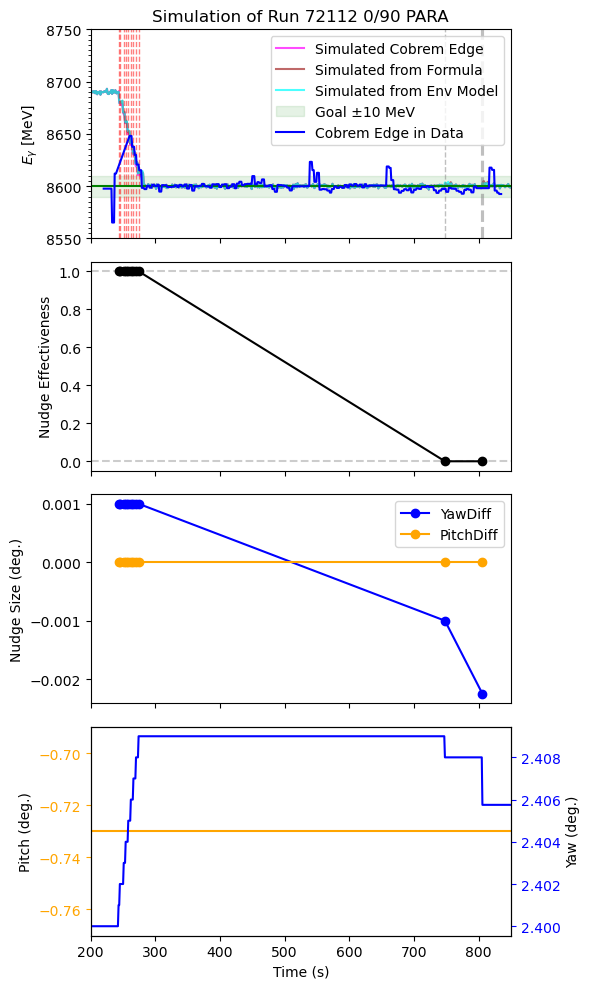

In [21]:
sim_72112 = sim_engine("2020",2)
#def generate_timeseries(self, num_seconds, input_energy, noise_size, energy_drift_model = 'None', model_params=[], auto_nudge = False):    
sim_72112.generate_timeseries(850,8690,1,"manual",[[242, 244, 250, 253, 257, 261, 265, 269, 273, 747, 805],[-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1.5]])
ax1_72112 = sim_72112.plot_result([200,850],[50,150],"Simulation of Run 72112 0/90 PARA","plots/simulated_run_72112.pdf")
plot_data_E_in_sim(df_2020,72112,ax1_72112,save_as="plots/simulated_run_72112_with_data.pdf")

run 72127 0/90 PERP

num_secs is 6
base_energy after nudge is 8605.0
base_energy_formula after nudge is 8605.010324282259
base_energy_env after nudge is 8605.010324282259
num_secs is 10
base_energy after nudge is 8595.0
base_energy_formula after nudge is 8594.948387655379
base_energy_env after nudge is 8594.948387655379
num_secs is 8
base_energy after nudge is 8595.0
base_energy_formula after nudge is 8594.948387655379
base_energy_env after nudge is 8594.948387655379
num_secs is 10
base_energy after nudge is 8595.0
base_energy_formula after nudge is 8594.948387655379
base_energy_env after nudge is 8594.948387655379
num_secs is 10
base_energy after nudge is 8604.0
base_energy_formula after nudge is 8604.07319608332
base_energy_env after nudge is 8604.133447960252
Nudge 0: pitch_diff=0.001000, yaw_diff=0.000000, total_angle=0.001000, linewidth=1.00
Nudge 1: pitch_diff=0.001000, yaw_diff=0.000000, total_angle=0.001000, linewidth=1.00
Nudge 2: pitch_diff=-0.001000, yaw_diff=0.000000, total_angle=0.001000, line

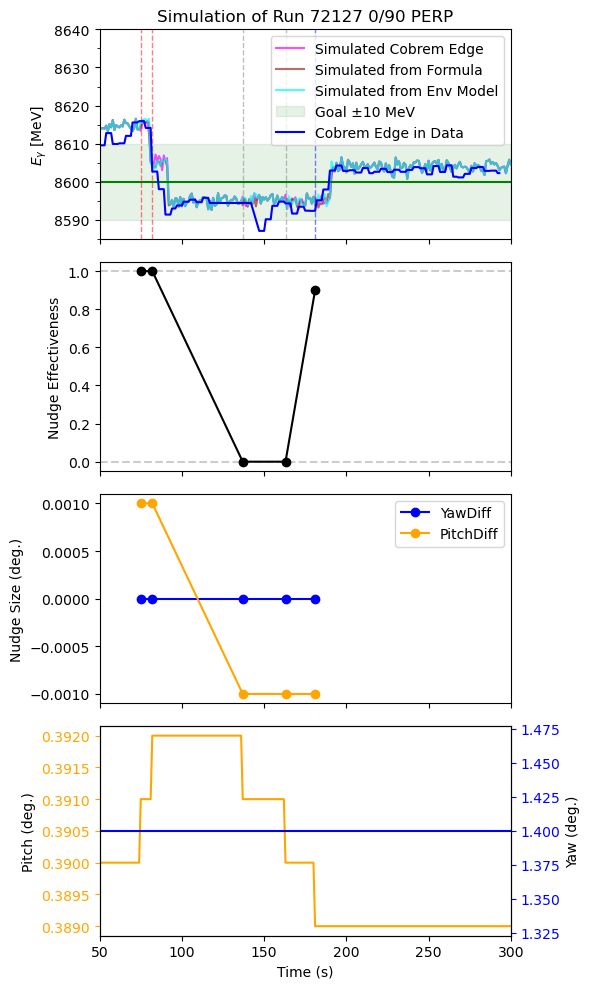

In [12]:
sim_72127 = sim_engine("2020",1)
sim_72127.generate_timeseries(300,8615,1,"manual",[[74,81,136,162,180],[-1,-1,1,1,1]])
ax1_72127 = sim_72127.plot_result([50,300],[15,40],"Simulation of Run 72127 0/90 PERP","plots/simulated_run_72127.pdf")
plot_data_E_in_sim(df_2020,72127,ax1_72127,save_as="plots/simulated_run_72127_with_data.pdf")

run 72105, 0/90 PERP

num_secs is 9
base_energy after nudge is 8610.0
base_energy_formula after nudge is 8610.046394642204
base_energy_env after nudge is 8610.046394642204
num_secs is 8
base_energy after nudge is 8600.0
base_energy_formula after nudge is 8600.020919158711
base_energy_env after nudge is 8600.020919158711
Nudge 0: pitch_diff=0.001000, yaw_diff=0.000000, total_angle=0.001000, linewidth=1.00
Nudge 1: pitch_diff=0.001000, yaw_diff=0.000000, total_angle=0.001000, linewidth=1.00
Nudge number 1 occurs at time 160.0 and has nudge effectiveness of 1.0
Nudge number 2 occurs at time 192.0 and has nudge effectiveness of 1.0


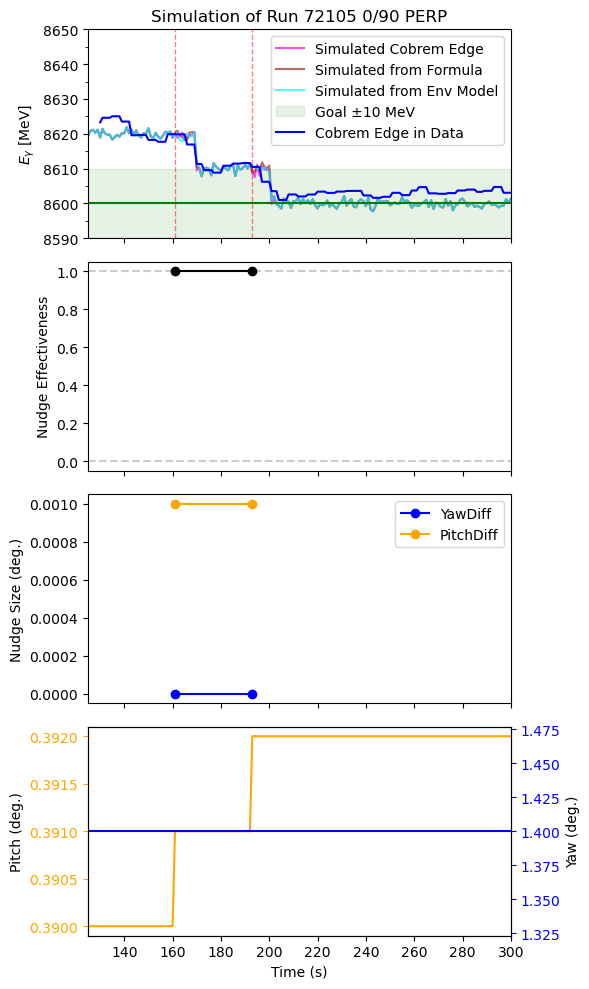

In [13]:
sim_72105 = sim_engine("2020",1)
sim_72105.generate_timeseries(300,8620,1,"manual",[[160,192],[-1,-1]])
ax1_72105 = sim_72105.plot_result([125,300],[10,50],"Simulation of Run 72105 0/90 PERP","plots/simulated_run_72105.pdf")
plot_data_E_in_sim(df_2020,72105,ax1_72105,save_as="plots/simulated_run_72105_with_data.pdf")

run 72160, 45/135 PARA

num_secs is 9
base_energy after nudge is 8620.0
base_energy_formula after nudge is 8620.118340350946
base_energy_env after nudge is 8620.118340350946
num_secs is 8
base_energy after nudge is 8610.0
base_energy_formula after nudge is 8610.165587921509
base_energy_env after nudge is 8610.165587921509
num_secs is 9
base_energy after nudge is 8600.0
base_energy_formula after nudge is 8600.140974598396
base_energy_env after nudge is 8600.140974598396
Nudge 0: pitch_diff=0.000707, yaw_diff=0.000707, total_angle=0.001000, linewidth=1.00
Nudge 1: pitch_diff=0.000707, yaw_diff=0.000707, total_angle=0.001000, linewidth=1.00
Nudge 2: pitch_diff=0.000707, yaw_diff=0.000707, total_angle=0.001000, linewidth=1.00
Nudge number 1 occurs at time 548.0 and has nudge effectiveness of 0.7
Nudge number 2 occurs at time 559.0 and has nudge effectiveness of 0.7
Nudge number 3 occurs at time 582.0 and has nudge effectiveness of 0.7


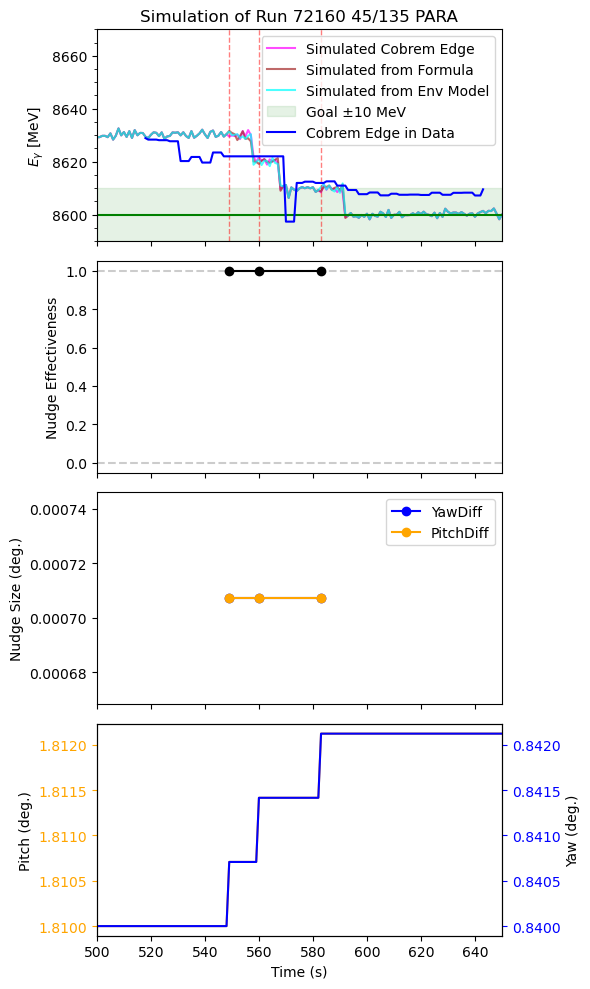

In [23]:
sim_72160 = sim_engine("2020",4)
sim_72160.generate_timeseries(700,8630,1,"manual",[[548, 559, 582],[-1, -1, -1]])
ax1_72160 = sim_72160.plot_result([500,650],[10,70],"Simulation of Run 72160 45/135 PARA","plots/simulated_run_72160.pdf")
plot_data_E_in_sim(df_2020,72160,ax1_72160,save_as="plots/simulated_run_72160_with_data.pdf")

run 73230 45/135 PERP

num_secs is 10
base_energy after nudge is 8600.0
base_energy_formula after nudge is 8600.0
base_energy_env after nudge is 8600.0
num_secs is 8
base_energy after nudge is 8600.0
base_energy_formula after nudge is 8600.0
base_energy_env after nudge is 8600.0
num_secs is 10
base_energy after nudge is 8600.213203435596
base_energy_formula after nudge is 8600.216067687341
base_energy_env after nudge is 8600.15280322276
num_secs is 9
base_energy after nudge is 8607.284271247461
base_energy_formula after nudge is 8607.363130174881
base_energy_env after nudge is 8605.229074491985
num_secs is 9
base_energy after nudge is 8614.355339059326
base_energy_formula after nudge is 8614.473495989769
base_energy_env after nudge is 8610.286786264012
Nudge 0: pitch_diff=-0.000707, yaw_diff=-0.000707, total_angle=0.001000, linewidth=1.00
Nudge 1: pitch_diff=-0.000707, yaw_diff=-0.000707, total_angle=0.001000, linewidth=1.00
Nudge 2: pitch_diff=-0.000707, yaw_diff=-0.000707, total_angle=0.001000, linewidth=1

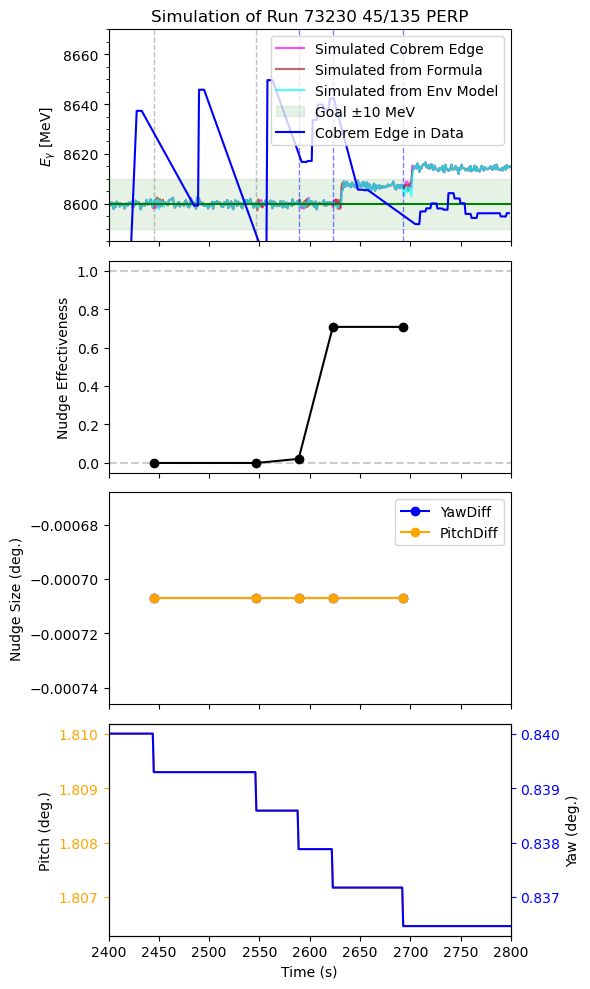

In [24]:
sim_73230 = sim_engine("2020",4)
sim_73230.generate_timeseries(2800,8600,1,"manual",[[2444, 2546, 2588, 2622, 2692],[1, 1, 1, 1, 1]])
ax1_73230 = sim_73230.plot_result([2400,2800],[15,70],"Simulation of Run 73230 45/135 PERP","plots/simulated_run_73230.pdf")
plot_data_E_in_sim(df_2020,73230,ax1_73230,save_as="plots/simulated_run_73230_with_data.pdf")

## Spring 2023

num_secs is 10
base_energy after nudge is 8615.0
base_energy_formula after nudge is 8615.0
base_energy_env after nudge is 8615.0
num_secs is 10
base_energy after nudge is 8615.0
base_energy_formula after nudge is 8615.0
base_energy_env after nudge is 8615.0
num_secs is 9
base_energy after nudge is 8624.0
base_energy_formula after nudge is 8625.146956929755
base_energy_env after nudge is 8625.146956929755
num_secs is 8
base_energy after nudge is 8624.0
base_energy_formula after nudge is 8625.146956929755
base_energy_env after nudge is 8625.146956929755
num_secs is 10
base_energy after nudge is 8624.0
base_energy_formula after nudge is 8625.146956929755
base_energy_env after nudge is 8625.146956929755
Nudge 0: pitch_diff=0.001000, yaw_diff=0.000000, total_angle=0.001000, linewidth=1.00
Nudge 1: pitch_diff=0.001000, yaw_diff=0.000000, total_angle=0.001000, linewidth=1.00
Nudge 2: pitch_diff=0.001000, yaw_diff=0.000000, total_angle=0.001000, linewidth=1.00
Nudge 3: pitch_diff=-0.001000, ya

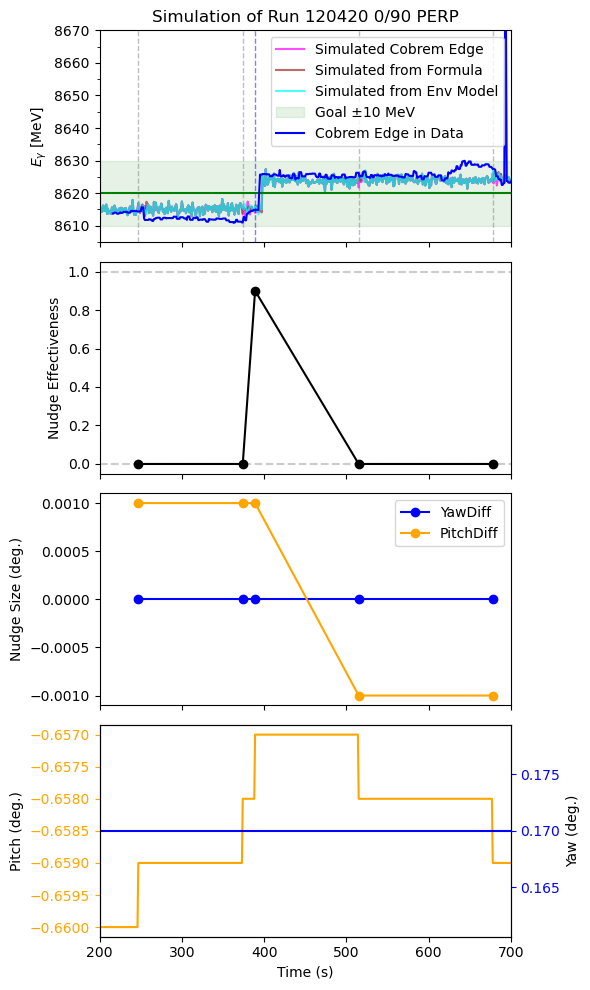

In [16]:
sim_120420 = sim_engine("2023",1)
sim_120420.generate_timeseries(700,8615,1,"manual",[[246, 373, 388, 514, 677],[1,1,1,-1,-1]])
ax1_120420 = sim_120420.plot_result([200,700],[15,50],"Simulation of Run 120420 0/90 PERP","plots/simulated_run_120420.pdf")
plot_data_E_in_sim(df_2023,120420,ax1_120420,save_as="plots/simulated_run_120420_with_data.pdf")

## Spring 2025

num_secs is 10
base_energy after nudge is 8930.000000000002
base_energy_formula after nudge is 8930.111157480957
base_energy_env after nudge is 8930.111157480957
num_secs is 9
base_energy after nudge is 8920.000000000004
base_energy_formula after nudge is 8920.15114469987
base_energy_env after nudge is 8920.15114469987
num_secs is 5
base_energy after nudge is 8910.000000000005
base_energy_formula after nudge is 8910.119192427075
base_energy_env after nudge is 8910.119192427075
num_secs is 9
base_energy after nudge is 8900.000000000007
base_energy_formula after nudge is 8900.014520327726
base_energy_env after nudge is 8900.014520327726
num_secs is 8
base_energy after nudge is 8890.00000000001
base_energy_formula after nudge is 8889.836336760962
base_energy_env after nudge is 8889.836336760962
num_secs is 10
base_energy after nudge is 8890.00000000001
base_energy_formula after nudge is 8889.836336760962
base_energy_env after nudge is 8889.836336760962
num_secs is 8
base_energy after nudg

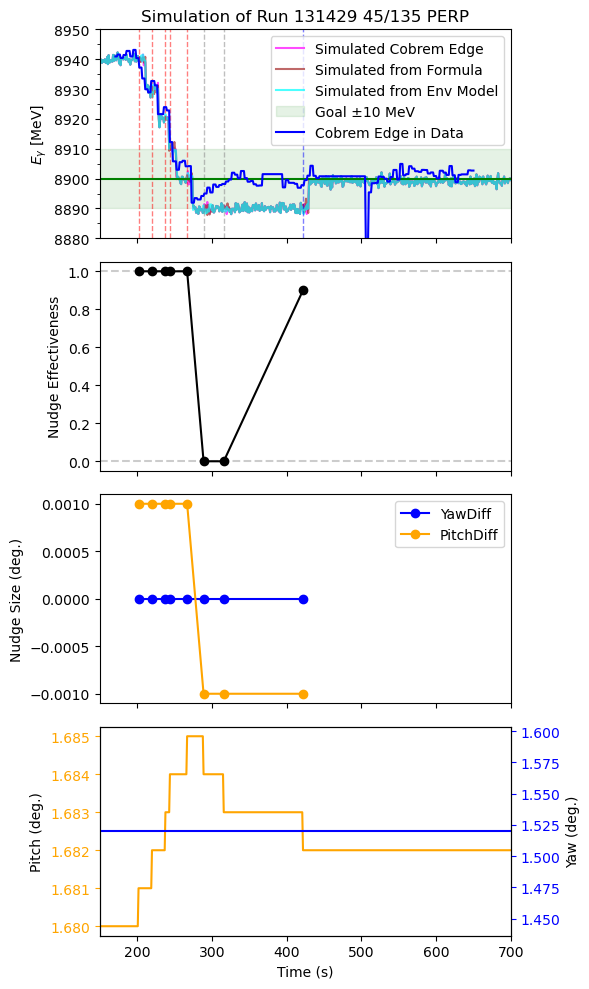

In [17]:
sim_131429 = sim_engine("2025",1)
sim_131429.generate_timeseries(700,8940,1,"manual",[[201, 219, 237, 243, 266, 288, 315, 421],[-1, -1, -1, -1, -1, 1,1,1]])
ax1_131429 = sim_131429.plot_result([150,700],[20,50],"Simulation of Run 131429 45/135 PERP","plots/simulated_run_131429.pdf")
plot_data_E_in_sim(df_2025,131429,ax1_131429,save_as="plots/simulated_run_131429_with_data.pdf")

num_secs is 8
base_energy after nudge is 8945.000000000002
base_energy_formula after nudge is 8945.218627501621
base_energy_env after nudge is 8945.218627501621
num_secs is 10
base_energy after nudge is 8935.000000000004
base_energy_formula after nudge is 8935.367241082678
base_energy_env after nudge is 8935.367241082678
num_secs is 10
base_energy after nudge is 8925.000000000005
base_energy_formula after nudge is 8925.4450881321
base_energy_env after nudge is 8925.4450881321
num_secs is 8
base_energy after nudge is 8915.000000000007
base_energy_formula after nudge is 8915.451405232818
base_energy_env after nudge is 8915.451405232818
num_secs is 9
base_energy after nudge is 8905.00000000001
base_energy_formula after nudge is 8905.385417967409
base_energy_env after nudge is 8905.385417967409
num_secs is 9
base_energy after nudge is 8895.000000000011
base_energy_formula after nudge is 8895.246340719546
base_energy_env after nudge is 8895.246340719546
num_secs is 10
base_energy after nudg

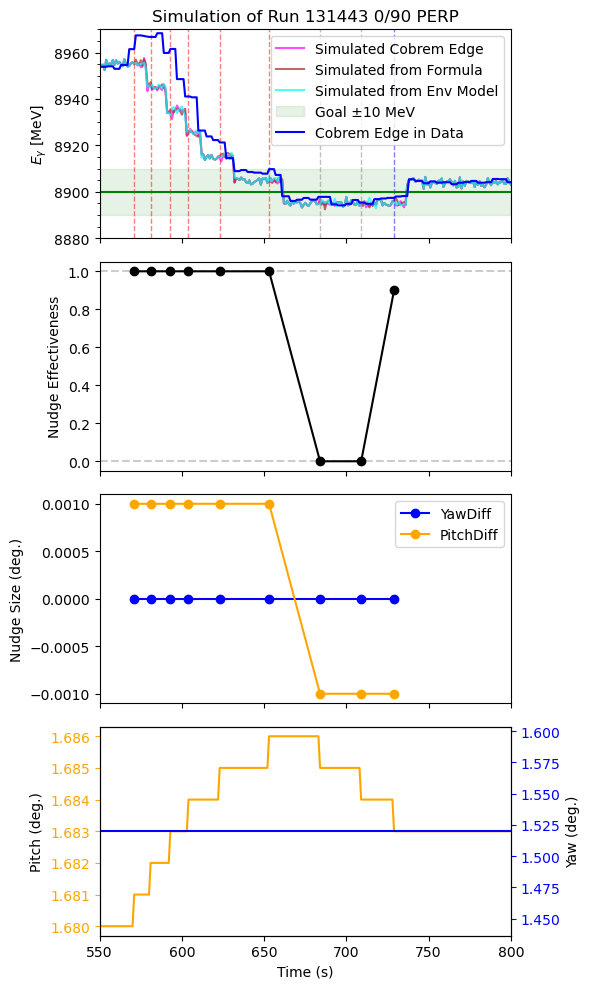

In [18]:
sim_131443 = sim_engine("2025",1)
sim_131443.generate_timeseries(800,8955,1,"manual",[[570, 580, 592, 603, 622, 652, 683, 708, 728],[-1, -1, -1, -1, -1, -1, 1, 1, 1]])
ax1_131443 = sim_131443.plot_result([550,800],[20,70],"Simulation of Run 131443 0/90 PERP","plots/simulated_run_131443.pdf")
plot_data_E_in_sim(df_2025,131443,ax1_131443,save_as="plots/simulated_run_131443_with_data.pdf")